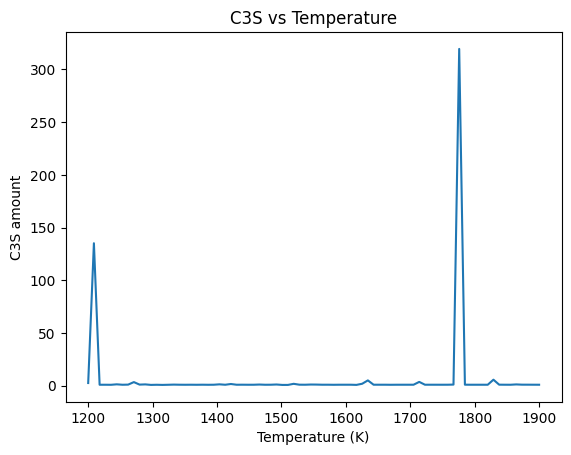

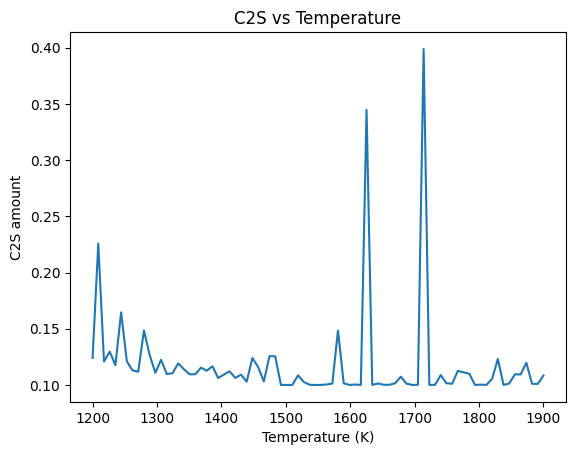

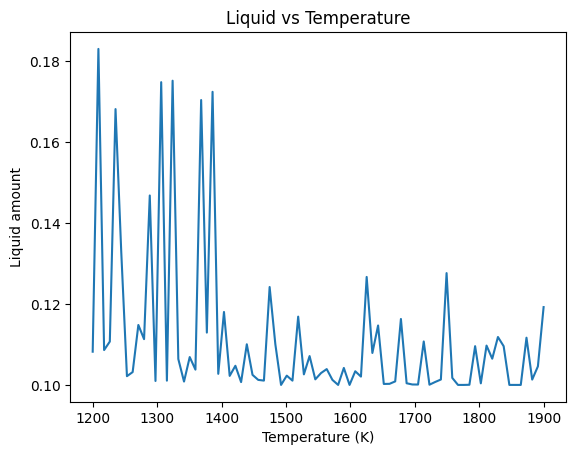

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

R = 8.314

temperatures = np.linspace(1200, 1900, 80)

xi1_list = []
xi2_list = []
liq_list = []

for T in temperatures:

    # ------------------------
    # Solid Gibbs energies
    # ------------------------
    def G_CaO(T):
        return -635090 + 109.4*T - 18.2*T*np.log(T)

    def G_SiO2(T):
        return -856000 + 150*T - 26*T*np.log(T)

    def G_C2S(T):
        return -2185000 + 260*T - 42*T*np.log(T)

    def G_C3S(T):
        return -3350000 + 380*T - 60*T*np.log(T)

    # Liquid standard state (slightly destabilised)
def G_CaO_liq(T):
    return G_CaO(T) + (60000 - 20*T)

def G_SiO2_liq(T):
    return G_SiO2(T) + (80000 - 25*T)

    # ------------------------
    # Total Gibbs
    # Variables:
    # x = [xi1, xi2, n_liq, x_liq]
    # ------------------------
    def total_G(x):

        xi1, xi2, nL, xL = x

        if xL <= 0 or xL >= 1:
            return 1e20

        # Solid amounts
        n_C2S = xi1
        n_C3S = xi2

        Ca_in_liq = nL * xL
        Si_in_liq = nL * (1 - xL)

        n_CaO = 3 - 2*xi1 - 3*xi2 - Ca_in_liq
        n_SiO2 = 1 - xi1 - xi2 - Si_in_liq

        if min(n_CaO, n_SiO2, n_C2S, n_C3S, nL) < 0:
            return 1e20

        G_solids = (
            n_CaO * G_CaO(T)
            + n_SiO2 * G_SiO2(T)
            + n_C2S * G_C2S(T)
            + n_C3S * G_C3S(T)
        )

        G_liq = nL * (
            xL * G_CaO_liq(T)
            + (1-xL) * G_SiO2_liq(T)
            + R*T*(xL*np.log(xL) + (1-xL)*np.log(1-xL))
        )

        return G_solids + G_liq

    bounds = [
        (0, None),   # xi1
        (0, None),   # xi2
        (0, None),   # nL
        (1e-6, 1-1e-6)  # xL
    ]

    result = minimize(
        total_G,
        [0.1, 0.1, 0.1, 0.5],
        method='SLSQP',
        bounds=bounds
    )

    xi1_list.append(result.x[0])
    xi2_list.append(result.x[1])
    liq_list.append(result.x[2])

xi1_list = np.array(xi1_list)
xi2_list = np.array(xi2_list)
liq_list = np.array(liq_list)

# ------------------------
# Plot results
# ------------------------

plt.figure()
plt.plot(temperatures, xi2_list)
plt.xlabel("Temperature (K)")
plt.ylabel("C3S amount")
plt.title("C3S vs Temperature")
plt.show()

plt.figure()
plt.plot(temperatures, xi1_list)
plt.xlabel("Temperature (K)")
plt.ylabel("C2S amount")
plt.title("C2S vs Temperature")
plt.show()

plt.figure()
plt.plot(temperatures, liq_list)
plt.xlabel("Temperature (K)")
plt.ylabel("Liquid amount")
plt.title("Liquid vs Temperature")
plt.show()